In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import scipy
import time
import torch

from pathlib import Path
from scipy.stats import binom_test, wilcoxon
from torch.distributions.transforms import AffineTransform

import lanfactory
import sbibm

from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
from sbi.analysis import pairplot
from utils import compile_df, huber_loss, mean_squared_error

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

BASE_DIR = Path.cwd().parent.as_posix()
data_folder = BASE_DIR + "/data/"
model_folder = BASE_DIR + "/notebooks/mnle-lan-comparison/models/"
save_folder = BASE_DIR + "/data/results/"

# Set log-likelihood lower bound for all methods, use 1e-7 as the highest bound used during training (e.g., for 10^11 budget LANs).
l_lower_bound = 1e-7
LL_LOWER_BOUND = np.log(l_lower_bound)

seed 223174


## Load DDM task from `sbibm`

In [3]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

# Load pre-simulated test data
with open(data_folder + "ddm_training_and_test_data_10mio.p", "rb") as fh:
    theta, x_1d, xos_1d, thos = pickle.load(fh).values()

num_simulations = 10_000

theta = theta[:num_simulations]

# encode x as (time, choice)
x = torch.zeros((num_simulations, 2))
x[:, 0] = abs(x_1d[:num_simulations, 0])
x[x_1d[:num_simulations, 0] > 0, 1] = 1

# encode xos as (time, choice)
xos = torch.zeros((xos_1d.shape[0], 2))
xos[:, 0] = abs(xos_1d[:, 0])
xos[xos_1d[:, 0] > 0, 1] = 1

### Load pretrained LANs

In [4]:
def load_lan(budget):
    lan_model_folder = Path.cwd() / f"mnle-lan-comparison/data/torch_models/ddm_{budget}/"  # Pathlib object
    network_file_path = list(lan_model_folder.glob(f"*_ddm_{budget}_torch_state_dict.pt"))[0]

    # get network config from model folder.
    with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

    # load model
    network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = 6)  # 4 params plus 2 data dims

    return network_file_path, network

lan_path_5, lan_5 = load_lan(budget="10_5_ours")
lan_path_8, lan_8 = load_lan(budget="10_8_ours")
lan_path_11, lan_11 = load_lan(budget="10_11")

tanh
linear
tanh
linear
tanh
tanh
linear


In [5]:
def score_mnle(path_to_model, num_observations, num_thetas_per_observation):

    # load model
    with open(path_to_model, "rb") as fh:
        mnle, *_ = pickle.load(fh).values()

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_thetas = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)

        # Evaluate
        lps_mnle_i = mnle.log_prob(xos[idx].repeat(num_thetas_per_observation, 1), test_thetas).detach()

        # apply lower bound
        below_bound = lps_mnle_i < LL_LOWER_BOUND
        lps_mnle_i[below_bound] = LL_LOWER_BOUND
        lps_true_i = task.get_log_likelihood(test_thetas, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_mnle_i, lps_true_i),
            huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_mnle_i, lps_true_i),
            mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)

# Transform scales param "a" by 0.5
lan_transform = AffineTransform(torch.zeros(1, 4), torch.tensor([[1.0, 0.5, 1.0, 1.0]]))

def lan_likelihood(theta, data, net, transform=True, correct_for_transform = False):
    """Return log likelihood summed over all trials in data, 
        given a batch of parameters theta.
    
    Args
        theta: batch of parameters
        data: batch of iid reaction times and choices encoded
            as negative and positive reaction times. 
        net: lan keras model
        
    Returns
        llsum: batch of log likelihoods over trials. 
    """
    
    # Convert to positive rts.
    rts = abs(data)
    num_trials = rts.numel()
    assert num_trials == 1, "this function assumes single trials."
    num_parameters = theta.shape[0]
    assert rts.shape == torch.Size([num_trials, 1])
    theta = torch.tensor(theta, dtype=torch.float32)
    # Convert DDM boundary seperation to symmetric boundary size.
    theta_lan = lan_transform(theta) if transform else theta

    # Code down -1 up +1.
    cs = torch.ones_like(rts)
    cs[data < 0] *= -1

    batch = torch.hstack((theta_lan, rts.repeat(num_parameters, 1), cs.repeat(num_parameters, 1)))

    # Evaluate LAN on batch (as suggested in LANfactory README.)
    logabsdet = lan_transform.log_abs_det_jacobian(theta_lan, theta)
    return net(batch).squeeze() + logabsdet.sum(1) if correct_for_transform else net(batch).squeeze()

def score_lan(network_file_path, num_observations, num_thetas_per_observation, transform=True):

    # get network config from model folder.
    with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

    # load model
    network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = 6)  # 4 params plus 2 data dims

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_thetas = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        
        # Evaluate
        lps_lankde_i = lan_likelihood(test_thetas, xoi, network, transform=transform)
        # apply lower bound
        below_bound = lps_lankde_i < LL_LOWER_BOUND
        lps_lankde_i[below_bound] = LL_LOWER_BOUND
        lps_true_i = task.get_log_likelihood(test_thetas, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_lankde_i, lps_true_i),
            huber_loss(lps_lankde_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_lankde_i, lps_true_i),
            mean_squared_error(lps_lankde_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)


def get_lan_likelihood_data_batch(theta, rts, choices, net, transform=True, correct_for_transform=False):
    theta_lan = lan_transform(theta) if transform else theta
    lan_batch = torch.hstack((
        theta_lan.repeat(rts.shape[0], 1), 
        rts, 
        choices,
        ))

    # Evaluate LAN on batch (as suggested in LANfactory README.)
    logabsdet = lan_transform.log_abs_det_jacobian(theta_lan, theta)
    lps_lan = net(lan_batch).squeeze() - logabsdet.sum(1) if correct_for_transform else net(lan_batch).squeeze()
    below_bound = lps_lan < LL_LOWER_BOUND
    lps_lan[below_bound] = LL_LOWER_BOUND

    return lps_lan

def get_lan_likelihood_batch_of_trials(theta, rts, choices, net, transform=True):

    theta_lan = lan_transform(theta) if transform else theta

    num_parameters = theta_lan.shape[0]
    num_trials = rts.shape[0]

    # Evaluate LAN on batch (as suggested in LANfactory README.)
    batch = torch.hstack((
        theta_lan.repeat(num_trials, 1),  # repeat params for each trial
        rts.repeat_interleave(num_parameters, dim=0),  # repeat data for each param
        choices.repeat_interleave(num_parameters, dim=0))
    )
    log_likelihood_trials = net(batch).reshape(num_trials, num_parameters)

    # Sum over trials.
    return log_likelihood_trials.sum(0).squeeze() 

# Helper function for bar plots below.
def plot_bar(pos, width, metrics, label, color, alpha=.6):
    plt.bar(
            pos, 
            height=metrics.mean(0), 
            width=width,
            yerr=metrics.std(0) / np.sqrt(metrics.shape[0]), 
            color = color,
            label=label,
            alpha=alpha,
            )

## Likelihood comparison for single example

##### Sample example parameter from prior

For creating a figure showing the likelihood over the entire data space given a fixed parameter combination we sample a single parameter combination from the prior and evaluate the synthetic likelihoods for a large range of reaction times and both choices, while holding the parameters fixed.

In [6]:
# Sample one parameter from the prior for a likelihood example.
# theta_o = prior.sample((1,))
l_lower_bound = 1e-7
theta_o = torch.tensor([[-.6, 1.6, 0.5, 0.3]])
theta_o

tensor([[-0.6000,  1.6000,  0.5000,  0.3000]])

In [7]:
# Load pretrained MNLE model
budget = 100000
model_paths = list(Path(model_folder).glob(f"*n{budget}_new_*"))
path_to_mnle = model_paths[5]

with open(path_to_mnle, "rb") as fh:
        mnle, *_ = pickle.load(fh).values()

In [8]:
# construct rts and choices for mnle in [-test_tmax, test_tmax]

# RT range
test_tmax = 2
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, l_lower_bound, ntest//2), 
           torch.linspace(l_lower_bound, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_x = torch.hstack((rs, cs))
test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

# get NLE synthetic likelihood for each data point with fixed theta.
lps_mnle = mnle.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
below_bound = lps_mnle < LL_LOWER_BOUND
lps_mnle[below_bound] = LL_LOWER_BOUND

lps_lan_5 = get_lan_likelihood_data_batch(theta_o, rs, torch.cat((-torch.ones(ntest//2), torch.ones(ntest//2))).reshape(-1, 1), lan_5, transform=False)
lps_lan_8 = get_lan_likelihood_data_batch(theta_o, rs, torch.cat((-torch.ones(ntest//2), torch.ones(ntest//2))).reshape(-1, 1), lan_8, transform=False)
lps_lan_11 = get_lan_likelihood_data_batch(theta_o, rs, torch.cat((-torch.ones(ntest//2), torch.ones(ntest//2))).reshape(-1, 1), lan_11)

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])



/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


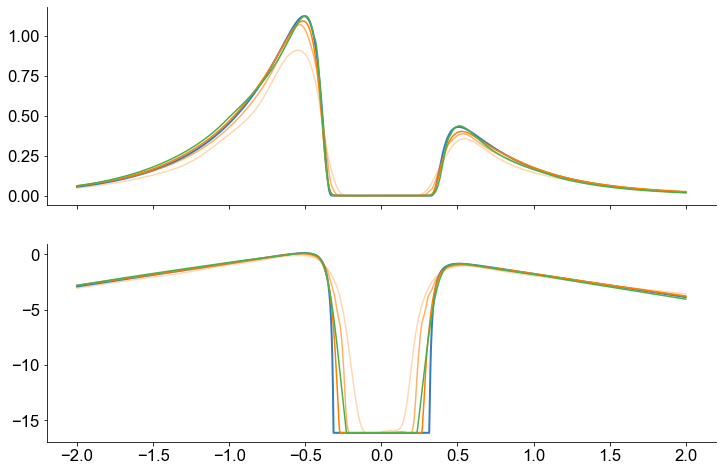

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
plt.sca(ax[0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0], lw=2);
plt.plot(test_rts, lps_lan_5.exp(), label="LAN-10^5", ls="-", c=colors[1], alpha=0.3);
plt.plot(test_rts, lps_lan_8.exp(), label="LAN-10^8", ls="-", c=colors[1], alpha=0.6);
plt.plot(test_rts, lps_lan_11.exp(), label="LAN-10^11", ls="-", c=colors[1], alpha=1.0);
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2]);

plt.sca(ax[1])
plt.plot(test_rts, lps_true, label="Analytical L", c=colors[0], lw=2);
plt.plot(test_rts, lps_lan_5, label="LAN-10^5", ls="-", c=colors[1], alpha=0.3);
plt.plot(test_rts, lps_lan_8, label="LAN-10^8", ls="-", c=colors[1], alpha=0.6);
plt.plot(test_rts, lps_lan_11, label="LAN-10^11", ls="-", c=colors[1], alpha=1.0);
plt.plot(test_rts, lps_mnle, label="MNLE", ls="-", c=colors[2]);


## Systematic Likelihood comparison

Next we do a systematic comparison based on the Huber loss (the LAN training loss) and the mean squared error (MSE) between analytical and synthetic log likelihoods of LAN and NLE.

During inference the observation is usually fixed and one evaluates the likelihood for a set of parameters sampled from the prior or a MCMC chain. To mimick this inference setup when comparison the estimated likelihoods, we sample an observation from the simulator given parameters from the prior, and obtain the likelihood of this observation given a large batch of parameters sampled from the prior, e.g., `1000`. The Huber loss and MSE are then calculated across this batch, resulting in a single number. We repeat this procedure for many observation, e.g., `100`, and then show boxplots over the resulting 100 numbers. 

In [10]:
num_observations = 100
num_thetas_per_observation = 1000

errors_mnle = score_mnle(path_to_mnle, num_observations, num_thetas_per_observation)
errors_lan_5 = score_lan(lan_path_5,  num_observations, num_thetas_per_observation, transform=False)
errors_lan_8 = score_lan(lan_path_8,  num_observations, num_thetas_per_observation, transform=False)
errors_lan_11 = score_lan(lan_path_11, num_observations, num_thetas_per_observation)

tanh
linear
tanh
linear


/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tanh
tanh
linear


In [11]:
import pandas as pd
labels = ["Analytical", 
          r"LAN$^5$", 
          r"LAN$^8$", 
          r"LAN$^{11}$", 
          r"MNLE$^5$", 
         ]

df_huber_log = pd.DataFrame(data=np.hstack((errors_lan_5[:, :1], errors_lan_8[:, :1], errors_lan_11[:, :1], errors_mnle[:, :1])), columns=labels[1:])
df_mse_log = pd.DataFrame(data=np.hstack((errors_lan_5[:, 2:3], errors_lan_8[:, 2:3], errors_lan_11[:, 2:3], errors_mnle[:, 2:3])), columns=labels[1:])
df_huber = pd.DataFrame(data=np.hstack((errors_lan_5[:, 1:2], errors_lan_8[:, 1:2], errors_lan_11[:, 1:2], errors_mnle[:, 1:2])), columns=labels[1:])
df_mse = pd.DataFrame(data=np.hstack((errors_lan_5[:, 3:4], errors_lan_8[:, 3:4], errors_lan_11[:, 3:4], errors_mnle[:, 3:4])), columns=labels[1:])

## Estimate evaluation times

In [12]:
# Vary size of theta (number of MCMC chains in parallel)
num_chains = [10]
# Vary size of data (number of trials)
num_trials = [100]
reps = 100

lan_rts = np.zeros((len(num_chains), len(num_trials), reps))
mnle_rts = np.zeros_like(lan_rts)

thetas = prior.sample((num_chains[-1],))
xs = simulator(prior.sample((1,)).repeat(num_trials[-1], 1))

for ii in range(reps):
    for jj, nc in enumerate(num_chains): 
        for kk, nt in enumerate(num_trials):
            # LAN timing
            rts = abs(xs[:nt])
            cs = torch.ones_like(rts)
            cs[xs[:nt] < 0] = -1
            tic = time.time()
            get_lan_likelihood_batch_of_trials(thetas[:nc], rts, cs, lan_11)
            lan_rts[jj, kk, ii] = time.time() - tic

            # NLE timing
            xi = torch.zeros((nt, 2))
            xi[:, 0] = abs(xs[:nt, 0])
            xi[xs[:nt, 0] > 0, 1] = 1
            tic = time.time()
            mnle.log_prob_iid(xi, thetas[:nc])
            mnle_rts[jj, kk, ii] = time.time() - tic

# convert ot ms
lan_rts *= 1000
mnle_rts *= 1000

In [13]:
lan_rts.mean(), mnle_rts.mean()

(0.9496855735778809, 4.085354804992676)

## Results figure 1

- likelihood examples

- likelihood accuracy

- number of simulations

- evaluation time

/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


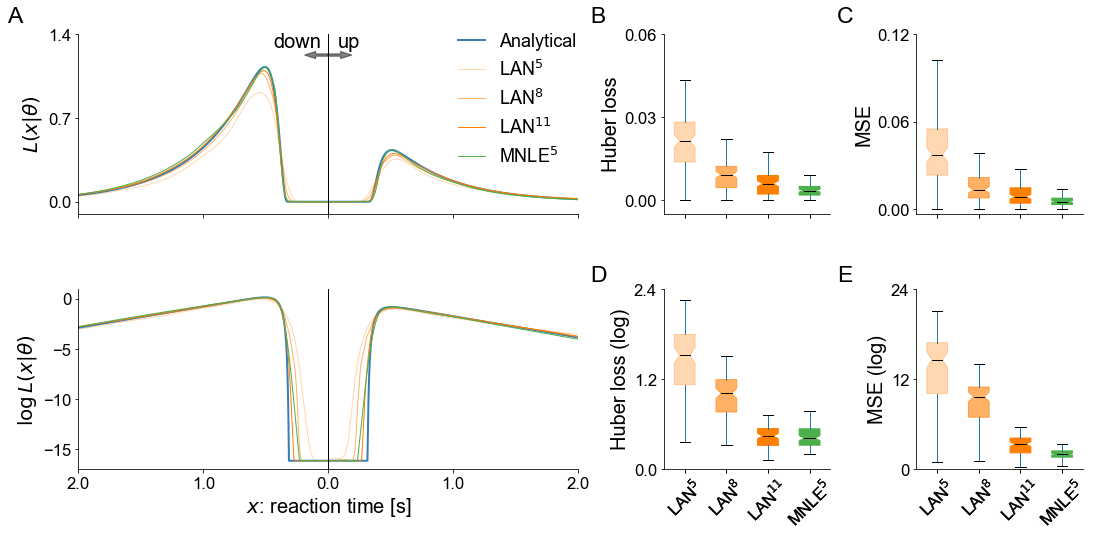

In [28]:
fig, ax = plt.subplots(2, 3, sharex="col", figsize=(18, 8), 
                       gridspec_kw=dict(wspace=0.31, hspace=0.42, width_ratios=[0.6, .2, .2]))

grid = False
showfliers = False
xticks = np.arange(-2, 2.1, 1)

alphas = [1, 0.3, 0.6, 1, 1]
plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]
rot = 45
mpl.rcParams["lines.linewidth"] = 1.


plt.sca(ax[0, 0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0], lw=2);
plt.plot(test_rts, lps_lan_5.exp(), label=labels[1], ls="-", c=colors[1], alpha=alphas[1]);
plt.plot(test_rts, lps_lan_8.exp(), label=labels[2], ls="-", c=colors[1], alpha=alphas[2]);
plt.plot(test_rts, lps_lan_11.exp(), label=labels[3], ls="-", c=colors[1], alpha=alphas[3]);
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.legend(labels, loc=1, handlelength=1.5, bbox_to_anchor=(1.03, 1.1))
plt.xticks(xticks, [])
plt.yticks(np.linspace(0, 1.4, 3))
plt.ylim([-.1, 1.4])
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)
y = max(lps_true.exp())+.1
plt.arrow(0, y, 0.1, 0., width=0.02, color="k", alpha=0.5)
plt.text(0.08, 1.05 * y, s="up")
plt.arrow(0, y, -0.1, 0., width=0.02, color="k", alpha=0.5)
plt.text(-.44, 1.05*y, s="down")
# plt.yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
# plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

plt.sca(ax[1, 0])
plt.plot(test_rts, lps_true, c=colors[0], lw=2)
# plt.plot(test_rts, lps_lanana)
plt.plot(test_rts, lps_lan_5, ls="-", c=colors[1], alpha=alphas[1])
plt.plot(test_rts, lps_lan_8, ls="-", c=colors[1], alpha=alphas[2])
plt.plot(test_rts, lps_lan_11, ls="-", c=colors[1], alpha=alphas[3])
plt.plot(test_rts, lps_mnle, ls="-", c=colors[2])
# plt.legend(labels)
plt.xlabel("$x$: reaction time [s]")
plt.ylabel(r"$\log L(x | \theta)$");
plt.xticks(xticks, abs(xticks))
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)

plt.sca(ax[0, 1])
box_widths = [0.5] * 4
bdict = df_huber.boxplot(ax=ax[0, 1], patch_artist=True, return_type="dict", 
                            medianprops={"color": "k"}, grid=grid, 
                           notch=True, 
                           widths=box_widths, 
                           showfliers=showfliers,
                           rot=rot,
                           )
plt.ylabel("Huber loss");
for i,box in enumerate(bdict['boxes']):
    box.set_color(plot_colors[i+1])
    box.set_alpha(alphas[i+1])
plt.yticks(np.linspace(0, 0.06, 3));
plt.ylim(-0.005, .06)

plt.sca(ax[0, 2])
bdict = df_mse.boxplot(ax=ax[0, 2], patch_artist=True, return_type="dict", 
                          medianprops={"color": "k"}, grid=grid, 
                          notch=True, 
                          widths=box_widths,
                          showfliers=showfliers,
                          rot=rot,
                         )
plt.ylabel(r"MSE");
for i,box in enumerate(bdict['boxes']):
    box.set_color(plot_colors[i+1])
    box.set_alpha(alphas[i+1])
plt.yticks(np.linspace(0, .12, 3))
plt.ylim(-0.003, .12);


plt.sca(ax[1, 1])
box_widths = [0.5] * 4
bdict = df_huber_log.boxplot(ax=ax[1, 1], patch_artist=True, return_type="dict", 
                            medianprops={"color": "k"}, grid=grid, 
                           notch=True, 
                           widths=box_widths, 
                           showfliers=showfliers,
                           rot=rot,
                           )
plt.ylabel("Huber loss (log)");
for i,box in enumerate(bdict['boxes']):
    box.set_color(plot_colors[i+1])
    box.set_alpha(alphas[i+1])
plt.yticks(np.linspace(0, 2.4, 3));
plt.ylim(0, 2.4)

plt.sca(ax[1, 2])
bdict = df_mse_log.boxplot(ax=ax[1, 2], patch_artist=True, return_type="dict", 
                          medianprops={"color": "k"}, grid=grid, 
                          notch=True, 
                          widths=box_widths,
                          showfliers=showfliers,
                          rot=rot,
                         )
plt.ylabel(r"MSE (log)");
for i,box in enumerate(bdict['boxes']):
    box.set_color(plot_colors[i+1])
    box.set_alpha(alphas[i+1])
plt.yticks(np.linspace(0, 24, 3))
plt.ylim(0, 24);

weight = "regular"
fontsize = 23
y1 = 0.9
x1 = 0.07
dx = .45
dx2 = 0.64
dy = 0.45
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1 - dy, "D", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1 - dy, "E", fontsize=fontsize, fontweight=weight);
plt.tight_layout()
# fig.savefig("figures/Figure2-MNLE-LAN-likelihood-comparison.png", dpi=300, bbox_inches="tight");

/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


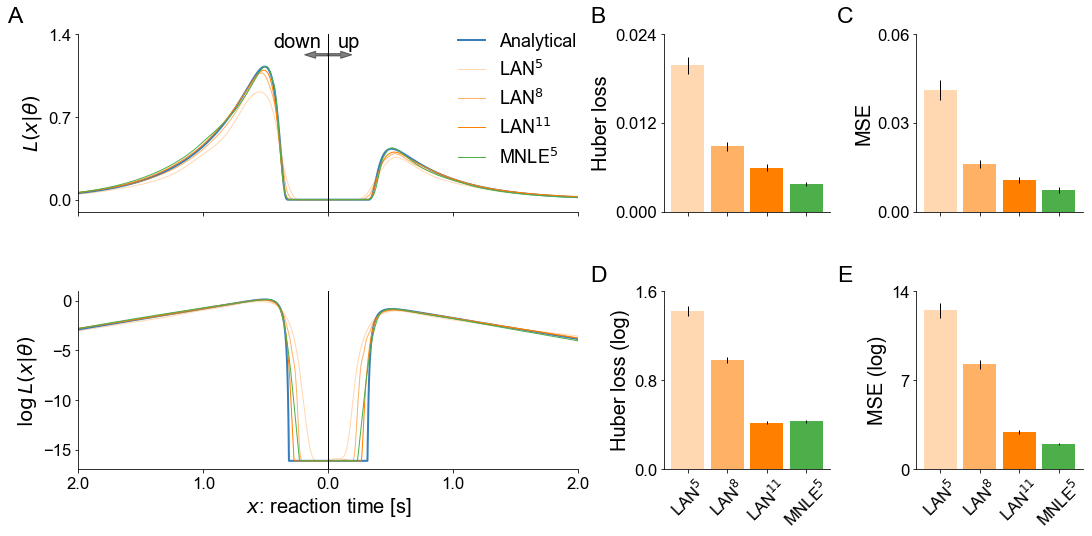

In [31]:
fig, ax = plt.subplots(2, 3, sharex="col", figsize=(18, 8),  
                       gridspec_kw=dict(wspace=0.31, hspace=0.45, width_ratios=[0.6, .2, .2]))

grid = False
showfliers = False
xticks = np.arange(-2, 2.1, 1)

alphas = [1, 0.3, 0.6, 1, 1]
plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]
rotation = 45
mpl.rcParams["lines.linewidth"] = 1.


plt.sca(ax[0, 0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0], lw=2);
plt.plot(test_rts, lps_lan_5.exp(), label=labels[1], ls="-", c=colors[1], alpha=alphas[1]);
plt.plot(test_rts, lps_lan_8.exp(), label=labels[2], ls="-", c=colors[1], alpha=alphas[2]);
plt.plot(test_rts, lps_lan_11.exp(), label=labels[3], ls="-", c=colors[1], alpha=alphas[3]);
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.legend(labels, loc=1, handlelength=1.5, bbox_to_anchor=(1.03, 1.1))
plt.xticks(xticks, [])
plt.yticks(np.linspace(0, 1.4, 3))
plt.ylim([-.1, 1.4])
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)
y = max(lps_true.exp())+.1
plt.arrow(0, y, 0.1, 0., width=0.02, color="k", alpha=0.5)
plt.text(0.08, 1.05 * y, s="up")
plt.arrow(0, y, -0.1, 0., width=0.02, color="k", alpha=0.5)
plt.text(-.44, 1.05*y, s="down")
# plt.yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
# plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

plt.sca(ax[1, 0])
plt.plot(test_rts, lps_true, c=colors[0], lw=2)
# plt.plot(test_rts, lps_lanana)
plt.plot(test_rts, lps_lan_5, ls="-", c=colors[1], alpha=alphas[1])
plt.plot(test_rts, lps_lan_8, ls="-", c=colors[1], alpha=alphas[2])
plt.plot(test_rts, lps_lan_11, ls="-", c=colors[1], alpha=alphas[3])
plt.plot(test_rts, lps_mnle, ls="-", c=colors[2])
# plt.legend(labels)
plt.xlabel("$x$: reaction time [s]")
plt.ylabel(r"$\log L(x | \theta)$");
plt.xticks(xticks, abs(xticks))
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)

plt.sca(ax[0, 1])
box_widths = [0.5] * 4
pos = []
width = 0.1
pos_scale = 0.12
for ii in range(4):
    pos.append(ii*pos_scale)
    plot_bar(pos[ii], width, df_huber.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation);

plt.ylabel("Huber loss");
plt.yticks(np.linspace(0, 0.024, 3));
plt.ylim(0, 0.024)

plt.sca(ax[0, 2])
for ii in range(4):
    plot_bar(pos[ii], width, df_mse.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation);
plt.ylabel(r"MSE");
plt.yticks(np.linspace(0, .06, 3))
plt.ylim(0, .06);


plt.sca(ax[1, 1])
for ii in range(4):
    plot_bar(pos[ii], width, df_huber_log.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation);
plt.ylabel("Huber loss (log)");
plt.yticks(np.linspace(0, 1.6, 3));
plt.ylim(0, 1.6)

plt.sca(ax[1, 2])
for ii in range(4):
    plot_bar(pos[ii], width, df_mse_log.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation);
plt.ylabel(r"MSE (log)");
plt.yticks(np.linspace(0, 14, 3))
plt.ylim(0, 14);

weight = "regular"
fontsize = 23
y1 = 0.9
x1 = 0.07
dx = .45
dx2 = 0.64
dy = 0.45
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1 - dy, "D", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1 - dy, "E", fontsize=fontsize, fontweight=weight);
plt.tight_layout()
fig.savefig("figures/Figure2-MNLE-LAN-likelihood-comparison.png", dpi=300, bbox_inches="tight");

### Medians and pairwise comparisons

In [85]:

df_huber_log.median(), df_mse_log.median()

(LAN$^5$       1.517449
 LAN$^8$       1.007157
 LAN$^{11}$    0.438134
 MNLE$^5$      0.410563
 dtype: float64,
 LAN$^5$       14.561678
 LAN$^8$        9.634312
 LAN$^{11}$     3.310703
 MNLE$^5$       1.956109
 dtype: float64)

In [80]:
df_huber.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_mse.columns = ["LAN5", "LAN8", "LAN", "MNLE"]

In [81]:
binom_test((df_huber.LAN>df_huber.MNLE).sum(), num_observations, 0.5)

0.006637120515926128

In [82]:
wilcoxon(df_huber.LAN, df_huber.MNLE, )

WilcoxonResult(statistic=867.0, pvalue=1.1928664494909583e-08)

In [83]:
binom_test((df_mse.LAN>df_mse.MNLE).sum(), num_observations, 0.5)

0.0035176417229701587

In [84]:
wilcoxon(df_mse.LAN, df_mse.MNLE, )

WilcoxonResult(statistic=846.0, pvalue=7.789675866010682e-09)